In [23]:
#Initialize some stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import UCSmpl

In [24]:
## Load the downloaded ENTSO-E data for 2025 to date
spain_raw = pd.read_csv("data/Actual Generation per Production Type_202501010000-202601010000.csv")

In [ ]:
# Clean up the data and column names, aggregate some stuff

# This creates a boolean mask where "-" appears, then drops those rows
spain_raw = spain_raw[~spain_raw.isin(["-"]).any(axis=1)].reset_index(drop=True)

# Sample format in 'MTU': '28.04.2025 00:00 - 28.04.2025 00:15 (CET/CEST)'

# Step 1: Extract the start timestamp (everything before ' - ')
spain_raw['start_time_str'] = spain_raw['MTU'].str.extract(r'^(.*?) -')

# Step 2: Convert to datetime (specifying dayfirst=True due to European date format)
spain_raw['start_time'] = pd.to_datetime(spain_raw['start_time_str'], dayfirst=True)

# Optionally drop the intermediate column
spain_raw.drop(columns='start_time_str', inplace=True)

# List the columns you want to drop
columns_to_drop = ['Area', 'MTU', 'Fossil Brown coal/Lignite - Actual Aggregated [MW]', 'Fossil Coal-derived gas - Actual Aggregated [MW]', 'Fossil Oil shale - Actual Aggregated [MW]', 'Fossil Peat - Actual Aggregated [MW]', 'Geothermal - Actual Aggregated [MW]', 'Marine - Actual Aggregated [MW]', 'Wind Offshore - Actual Aggregated [MW]']

# Create the new DataFrame without those columns
spain_clean = spain_raw.drop(columns=columns_to_drop)

# Define the new column names list
new_column_names = ['Biomass', 'Gas', 'Coal', 'Oil', 'PSH gen', 'PSH con', 'Small hydro', 'Large hydro', 'Nuclear', 'Other', 'Misc renewables', 'Solar', 'Waste', 'Wind', 'start_time']

# Assign the new column names
spain_clean.columns = new_column_names

# Convert energy source columns to numeric (just in case any values are still strings)
energy_columns = spain_clean.columns[:-1]  # all except 'start_time'
spain_clean[energy_columns] = spain_clean[energy_columns].apply(pd.to_numeric, errors='coerce')

# Define which columns go into each category
aggregations = {
    'Other renewables': ['Biomass', 'Misc renewables', 'Waste'],
    'Hydro': ['PSH gen', 'Small hydro', 'Large hydro'],
    'Gas': ['Gas'],
    'Coal': ['Coal'],
    'Other': ['Oil', 'Other'],
    'Nuclear': ['Nuclear'],
    'Solar': ['Solar'],
    'Wind': ['Wind']
}

# Create a new DataFrame for the aggregated categories
spain_agg = pd.DataFrame()
spain_agg['start_time'] = spain_clean['start_time']

# Add each category by summing the appropriate columns
for category, columns in aggregations.items():
    spain_agg[category] = spain_clean[columns].sum(axis=1)

spain_agg

,start_time,Other renewables,Hydro,Gas,Coal,Other,Nuclear,Solar,Wind
0,2025-01-01 00:00:00,648.0,2784.0,8608.0,512.0,16.0,7116.0,4.0,2856.0
1,2025-01-01 00:15:00,640.0,2980.0,8848.0,500.0,16.0,7116.0,4.0,2904.0
2,2025-01-01 00:30:00,628.0,2964.0,8716.0,468.0,16.0,7116.0,4.0,2972.0
3,2025-01-01 00:45:00,620.0,2876.0,8444.0,436.0,16.0,7116.0,4.0,3064.0
4,2025-01-01 01:00:00,616.0,2744.0,8276.0,392.0,16.0,7116.0,4.0,3096.0
...,...,...,...,...,...,...,...,...,...
18423,2025-07-11 21:45:00,816.0,5588.0,9072.0,0.0,84.0,6924.0,976.0,7460.0
18424,2025-07-11 22:00:00,824.0,6220.0,8996.0,0.0,84.0,6928.0,744.0,7368.0
18425,2025-07-11 22:15:00,820.0,6600.0,9444.0,0.0,84.0,6932.0,652.0,7416.0
18426,2025-07-11 22:30:00,820.0,6520.0,9332.0,0.0,88.0,6936.0,640.0,7444.0


In [28]:
# Add some columns to calculate renewables share per hour and day

# Total IBR (Solar + Wind) power at each timestamp
spain_agg['IBR_MW'] = spain_clean['Solar'] + spain_clean['Wind']

# Total generation at each timestamp (sum of all sources)
# Adjust column list as needed to include only generation sources
gen_cols = gen_cols = spain_agg.columns[1:]  # everything except 'start_time'
spain_agg['Total_Generation_MW'] = spain_agg[gen_cols].sum(axis=1)

# Hourly penetration as fraction
spain_agg['IBR_pc_hr'] = spain_agg['IBR_MW'] / spain_agg['Total_Generation_MW']

# Step 2: Extract date
spain_agg['date'] = spain_agg['start_time'].dt.date

# Step 3: Calculate daily IBR penetration
daily_ibr = spain_agg.groupby('date').agg({
    'IBR_MW': 'sum',
    'Total_Generation_MW': 'sum'
})
daily_ibr['IBR_pc_day'] = daily_ibr['IBR_MW'] / daily_ibr['Total_Generation_MW']

# Step 4: Map daily value back to the full dataframe
spain_agg['IBR_pc_day'] = spain_agg['date'].map(daily_ibr['IBR_pc_day'])

# Step 5: (Optional) drop the helper 'date' column
spain_agg = spain_agg.drop(columns='date')


spain_agg

,start_time,Other renewables,Hydro,Gas,Coal,Other,Nuclear,Solar,Wind,IBR_MW,Total_Generation_MW,IBR_pc_hr,IBR_pc_day
0,2025-01-01 00:00:00,648.0,2784.0,8608.0,512.0,16.0,7116.0,4.0,2856.0,2860.0,50808.112581,0.056290,0.115407
1,2025-01-01 00:15:00,640.0,2980.0,8848.0,500.0,16.0,7116.0,4.0,2904.0,2908.0,51832.112209,0.056104,0.115407
2,2025-01-01 00:30:00,628.0,2964.0,8716.0,468.0,16.0,7116.0,4.0,2972.0,2976.0,51720.115081,0.057540,0.115407
3,2025-01-01 00:45:00,620.0,2876.0,8444.0,436.0,16.0,7116.0,4.0,3064.0,3068.0,51288.119638,0.059819,0.115407
4,2025-01-01 01:00:00,616.0,2744.0,8276.0,392.0,16.0,7116.0,4.0,3096.0,3100.0,50720.122240,0.061120,0.115407
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18423,2025-07-11 21:45:00,816.0,5588.0,9072.0,0.0,84.0,6924.0,976.0,7460.0,8436.0,78712.214351,0.107175,0.146392
18424,2025-07-11 22:00:00,824.0,6220.0,8996.0,0.0,84.0,6928.0,744.0,7368.0,8112.0,78552.206538,0.103269,0.146392
18425,2025-07-11 22:15:00,820.0,6600.0,9444.0,0.0,84.0,6932.0,652.0,7416.0,8068.0,80032.201619,0.100809,0.146392
18426,2025-07-11 22:30:00,820.0,6520.0,9332.0,0.0,88.0,6936.0,640.0,7444.0,8084.0,79728.202789,0.101394,0.146392


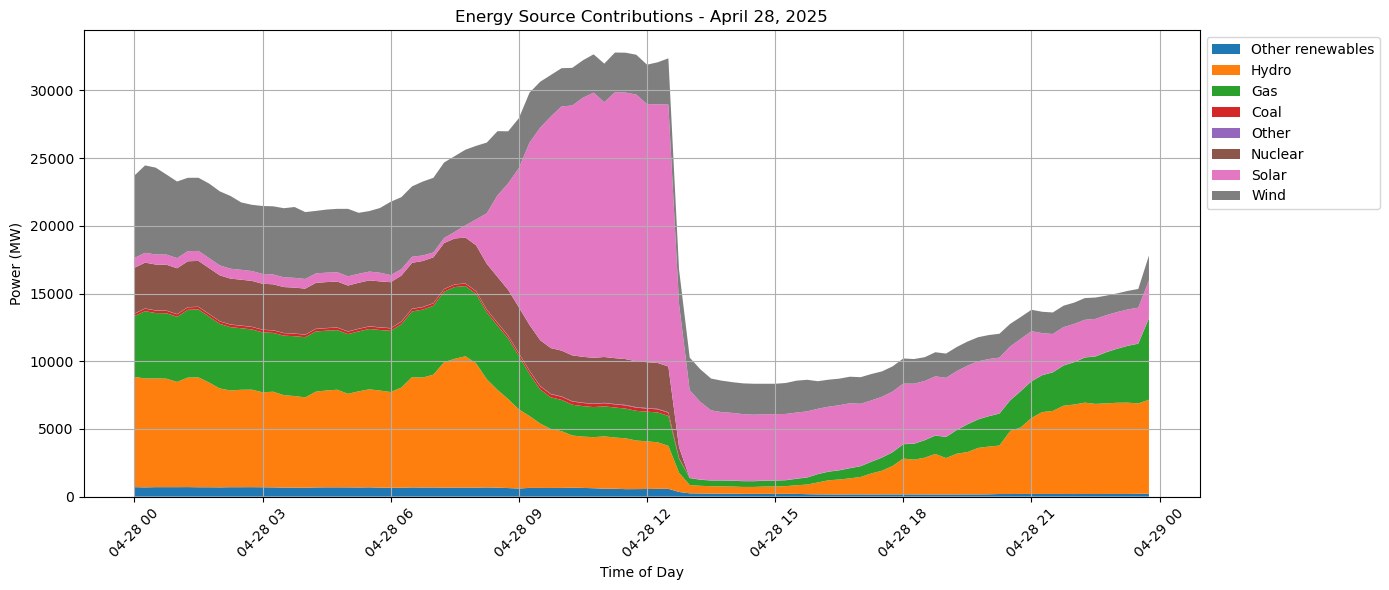

In [26]:
# Step 1: Filter for April 28, 2025
mask = spain_agg['start_time'].dt.date == pd.to_datetime('2025-04-28').date()
df_day = spain_agg[mask]

# Step 2: Extract energy source columns and timestamps
energy_sources = df_day.columns[1:]  # all columns except 'start_time'
timestamps = df_day['start_time']

# Step 3: Plot
plt.figure(figsize=(14, 6))
plt.stackplot(timestamps, df_day[energy_sources].T, labels=energy_sources)

# Step 4: Formatting
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('Energy Source Contributions - April 28, 2025')
plt.xlabel('Time of Day')
plt.ylabel('Power (MW)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
